# Notebook to explore visual processing

In [1]:
from flygym import Fly, Camera, SingleFlySimulation, Simulation, NeuroMechFly
from hybrid_turning_fly import HybridTurningFly
import cv2
import numpy as np
import pickle
from tqdm import trange
import flygym as flygym
from flygym.arena import FlatTerrain
from numpy.random import normal

from flygym.preprogrammed import all_leg_dofs
from flygym.vision import save_video_with_vision_insets

from pathlib import Path
import imageio
import matplotlib.pyplot as plt

## Chasing exemple

In [2]:
class VisualTaxisFly(HybridTurningFly):
    def __init__(self, obj_threshold=0.15, decision_interval=0.05, **kwargs):
        super().__init__(**kwargs, enable_vision=True)
        self.obj_threshold = obj_threshold
        self.decision_interval = decision_interval
        self.num_substeps = int(self.decision_interval / self.timestep)
        self.visual_inputs_hist = []

        self.coms = np.empty((self.retina.num_ommatidia_per_eye, 2))

        for i in range(self.retina.num_ommatidia_per_eye):
            mask = self.retina.ommatidia_id_map == i + 1
            self.coms[i, :] = np.argwhere(mask).mean(axis=0)

    def process_visual_observation(self, vision_input):
        features = np.zeros((2, 3))

        for i, ommatidia_readings in enumerate(vision_input):
            is_obj = ommatidia_readings.max(axis=1) < self.obj_threshold
            is_obj_coords = self.coms[is_obj]

            if is_obj_coords.shape[0] > 0:
                features[i, :2] = is_obj_coords.mean(axis=0)

            features[i, 2] = is_obj_coords.shape[0]

        features[:, 0] /= self.retina.nrows  # normalize y_center
        features[:, 1] /= self.retina.ncols  # normalize x_center
        features[:, 2] /= self.retina.num_ommatidia_per_eye  # normalize area
        return features.ravel().astype("float32")

    @staticmethod
    def calc_ipsilateral_speed(deviation, is_found):
        if not is_found:
            return 1.0
        else:
            return np.clip(1 - deviation * 3, 0.4, 1.2)

In [11]:
timestep = 1e-4

fly0 = VisualTaxisFly(
    name="0",
    timestep=timestep,
    enable_adhesion=True,
    head_stabilization_model="thorax",
    neck_kp=1000,
)

fly1 = HybridTurningFly(
    name="1",
    timestep=timestep,
    enable_adhesion=True,
    spawn_pos=(6, 0, 0.5),
)

arena = FlatTerrain()

birdeye_cam_zoom = arena.root_element.worldbody.add(
    "camera",
    name="birdeye_cam_zoom",
    mode="fixed",
    pos=(15, 0, 20),
    euler=(0, 0, 0),
    fovy=45,
)

birdeye_cam = arena.root_element.worldbody.add(
    "camera",
    name="birdeye_cam",
    mode="fixed",
    pos=(15, 0, 35),
    euler=(0, 0, 0),
    fovy=45,
)

cam = Camera(
    fly=fly0,
    camera_id="birdeye_cam",
    play_speed=0.5,
    window_size=(800, 608),
)

sim = Simulation(
    flies=[fly0, fly1],
    cameras=[cam],
    arena=arena,
    timestep=timestep,
)

In [12]:
# Reset the simulation and set fly 1 to be black
sim.reset(seed=0)
for i in fly1.model.find_all("geom"):
    sim.physics.named.model.geom_rgba[f"1/{i.name}"] = (0, 0, 0, 1)

# Define simulation parameters
run_time = 3
t = np.arange(0, run_time, timestep)

# Define fly 1 actions --> sinusoidal trajectory
fly1_actions = (
    np.column_stack(
        [
            np.abs(np.cos(t * np.pi / 2)),
            np.abs(np.sin(t * np.pi / 2)),
        ]
    )
    * 1.2
)

# Modifiy fly speed
mean_speed = 1.2  
std_dev_speed = 0.4  
random_speed_variation = normal(loc=0, scale=std_dev_speed, size=fly1_actions.shape)
fly1_actions += random_speed_variation
fly1_actions = np.clip(fly1_actions, 0, 2 * mean_speed)

# Prepare simulation
second_cam_frames = []
fly0_action = np.zeros(2)
x = None
alpha = 1e-1

# Run simulation for each timepoint
for i in trange(len(t)):
    obs, _, _, _, info = sim.step(
        {
            "0": fly0_action,
            "1": fly1_actions[i],
        }
    )

    obs0, info0 = obs["0"], info["0"]
    render_res = sim.render()[0]

    # If frame is rendered, save it
    if render_res is not None:
        fly0.visual_inputs_hist.append(obs0["vision"].copy())
        second_cam = sim.physics.bind(birdeye_cam_zoom)

        x_new = sim._get_center_of_mass()[0]

        if x is None:
            x = x_new

        x = (1 - alpha) * x + alpha * x_new

        second_cam.pos[0] = x
        second_img = sim.physics.render(
            width=700, height=560, camera_id="birdeye_cam_zoom"
        )
        second_img = cv2.putText(
            np.ascontiguousarray(second_img),
            f"{sim.cameras[0].play_speed}x",
            org=(20, 30),
            fontFace=cv2.FONT_HERSHEY_DUPLEX,
            fontScale=0.8,
            color=(0, 0, 0),
            lineType=cv2.LINE_AA,
            thickness=1,
        )
        second_cam_frames.append(second_img)

    # Process visual input for fly 0
    visual_features = fly0.process_visual_observation(obs0["vision"])

    left_deviation = 1 - visual_features[1]
    right_deviation = visual_features[4]
    left_found = visual_features[2] > 0.005
    right_found = visual_features[5] > 0.005

    if not left_found:
        left_deviation = np.nan

    if not right_found:
        right_deviation = np.nan

    # Calculate fly 0 action
    fly0_action = np.array(
        [
            fly0.calc_ipsilateral_speed(left_deviation, left_found),
            fly0.calc_ipsilateral_speed(right_deviation, right_found),
        ]
    )

100%|██████████| 30000/30000 [16:16<00:00, 30.73it/s]  


In [14]:
birdeye_cam_frames = cam._frames
cam._frames = second_cam_frames
sim.fly = fly0

save_video_with_vision_insets(
    sim,
    cam,
    "outputs/fly_following_with_retina_images.mp4",
    fly0.visual_inputs_hist,
)

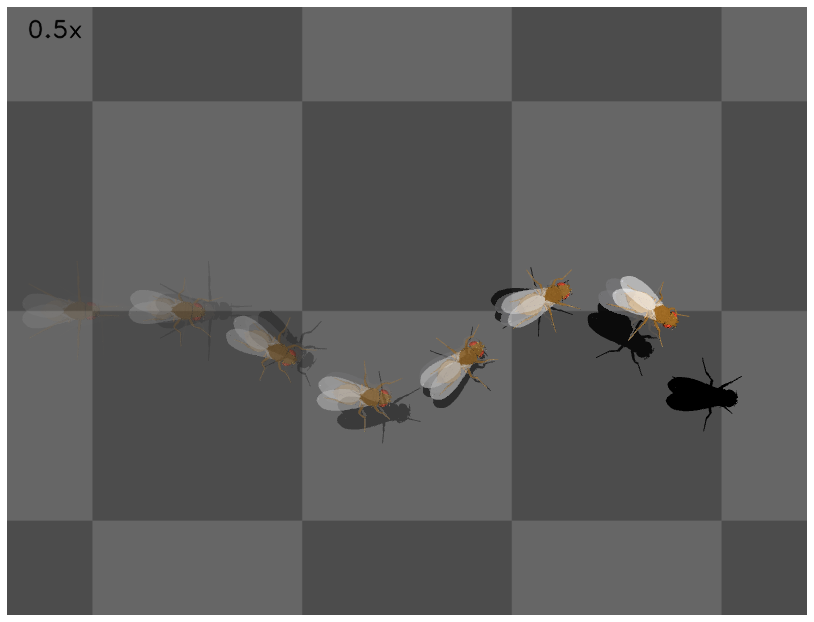

In [15]:
# Save overlayed frames
frame_indices = np.arange(0, len(birdeye_cam_frames), 30)[:8]
snapshots = [birdeye_cam_frames[i] for i in frame_indices]
background = np.median(snapshots, axis=0).astype("uint8")

individual_frames_dir = Path("outputs/individual_frames")
individual_frames_dir.mkdir(parents=True, exist_ok=True)

imageio.imwrite(individual_frames_dir / "background.png", background)
imgs = []

for i, img in enumerate(snapshots):
    is_background = np.isclose(img, background, atol=1).all(axis=2)
    img_alpha = np.ones((img.shape[0], img.shape[1], 4)) * 255
    img_alpha[:, :, :3] = img
    img_alpha[is_background, 3] = 0
    img_alpha = img_alpha.astype(np.uint8)
    imageio.imwrite(individual_frames_dir / f"frame_{i}.png", img_alpha)
    imgs.append(img_alpha.copy())

dpi = 72
h, w = background.shape[:2]

fig, ax = plt.subplots(figsize=(w / dpi, h / dpi), dpi=72)
ax.imshow(background)
ax.axis("off")

for i, img in enumerate(imgs):
    ax.imshow(img, alpha=(i + 1) / len(imgs))

fig.subplots_adjust(0, 0, 1, 1, 0, 0)
plt.savefig("outputs/overlayed_frames.pdf", dpi=dpi)

## Update visual processing to get distance

In [19]:
class ChasingFly(HybridTurningFly):
    def __init__(self, other_fly, desired_distance, obj_threshold=0.15, decision_interval=0.05, **kwargs):
        super().__init__(**kwargs, enable_vision=True)
        self.other_fly = other_fly  # The other fly that this fly is following
        self.desired_distance = desired_distance  # The desired distance to maintain from the other fly
        self.obj_threshold = obj_threshold
        self.decision_interval = decision_interval
        self.num_substeps = int(self.decision_interval / self.timestep)
        self.visual_inputs_hist = []

        self.coms = np.empty((self.retina.num_ommatidia_per_eye, 2))

        for i in range(self.retina.num_ommatidia_per_eye):
            mask = self.retina.ommatidia_id_map == i + 1
            self.coms[i, :] = np.argwhere(mask).mean(axis=0)

    def process_visual_observation(self, vision_input):
        features = np.zeros((2, 3))
        dist = np.zeros(2)

        for i, ommatidia_readings in enumerate(vision_input):
            is_obj = ommatidia_readings.max(axis=1) < self.obj_threshold
            is_obj_coords = self.coms[is_obj]

            if is_obj_coords.shape[0] > 0:
                features[i, :2] = is_obj_coords.mean(axis=0)
                # Estimate the distance to the other fly by counting the number of "pixels" perceiving the other fly
                dist[i] = is_obj.sum()

            features[i, 2] = is_obj_coords.shape[0]

        features[:, 0] /= self.retina.nrows  # normalize y_center
        features[:, 1] /= self.retina.ncols  # normalize x_center
        features[:, 2] /= self.retina.num_ommatidia_per_eye  # normalize area
        # Normalize distance (you may need to adjust this depending on the scale of your simulation)
        dist /= self.retina.num_ommatidia_per_eye  # normalize distance by the total number of "pixels"
        return features.ravel().astype("float32"), dist.sum()

    def calc_ipsilateral_speed(self, deviation, is_found, distance):
        """
        Calculates the ipsilateral speed based on deviation, object detection, and distance to the other fly.

        Parameters:
        - deviation (float): The deviation from the desired trajectory.
        - is_found (bool): Indicates whether an object is found.
        - distance (float): The distance to the other fly.

        Returns:
        - speed (float): The calculated ipsilateral speed.

        """
        if not is_found:
            return 1.0
        else:
            return np.clip(1 - deviation * 3, 0.4, 1.2)
            # Adjust the speed based on the distance to the other fly
            # if distance > self.desired_distance:
            #     return np.clip(1 - deviation * 3, 0.4, 1.2)
            # else:
            #     return np.clip(1 - deviation * 3, 0.4, 1.2)

    def calc_walking_speed(self, distance):
        """
        Calculates the walking speed based on the distance to the other fly.

        Parameters:
        - distance (float): The distance to the other fly.

        Returns:
        - speed (float): The calculated walking speed.
        """
        # Define your function for calculating the walking speed here.
        # This is just an example, you may need to adjust it based on your specific requirements.
        speed = np.clip(1 - distance * 3, 0.7, 1.3)
        return speed

In [20]:
timestep = 1e-4

fly1 = HybridTurningFly(
    name="1",
    timestep=timestep,
    enable_adhesion=True,
    spawn_pos=(6, 0, 0.5),
)

fly0 = ChasingFly(
    name="0",
    other_fly=fly1,
    desired_distance=0.02,
    timestep=timestep,
    enable_adhesion=True,
    head_stabilization_model="thorax",
    neck_kp=1000,
)

arena = FlatTerrain()

birdeye_cam_zoom = arena.root_element.worldbody.add(
    "camera",
    name="birdeye_cam_zoom",
    mode="fixed",
    pos=(15, 0, 20),
    euler=(0, 0, 0),
    fovy=45,
)

birdeye_cam = arena.root_element.worldbody.add(
    "camera",
    name="birdeye_cam",
    mode="fixed",
    pos=(15, 0, 35),
    euler=(0, 0, 0),
    fovy=45,
)

cam = Camera(
    fly=fly0,
    camera_id="birdeye_cam",
    play_speed=0.5,
    window_size=(800, 608),
)

sim = Simulation(
    flies=[fly0, fly1],
    cameras=[cam],
    arena=arena,
    timestep=timestep,
)

# Reset the simulation and set fly 1 to be black
sim.reset(seed=0)
for i in fly1.model.find_all("geom"):
    sim.physics.named.model.geom_rgba[f"1/{i.name}"] = (0, 0, 0, 1)

# Define simulation parameters
run_time = 3
t = np.arange(0, run_time, timestep)

# Define fly 1 actions --> sinusoidal trajectory
fly1_actions = (
    np.column_stack(
        [
            np.abs(np.cos(t * np.pi / 2)),
            np.abs(np.sin(t * np.pi / 2)),
        ]
    )
    * 1.2
)

# Modifiy fly speed
mean_speed = 1.2  
std_dev_speed = 0.4  
random_speed_variation = normal(loc=0, scale=std_dev_speed, size=fly1_actions.shape)
fly1_actions += random_speed_variation
fly1_actions = np.clip(fly1_actions, 0, 2 * mean_speed)

# Prepare simulation
second_cam_frames = []
fly0_action = np.zeros(2)
x = None
alpha = 1e-1

# Run simulation for each timepoint
for i in trange(len(t)):
    obs, _, _, _, info = sim.step(
        {
            "0": fly0_action,
            "1": fly1_actions[i],
        }
    )

    obs0, info0 = obs["0"], info["0"]
    render_res = sim.render()[0]

    # If frame is rendered, save it
    if render_res is not None:
        fly0.visual_inputs_hist.append(obs0["vision"].copy())
        second_cam = sim.physics.bind(birdeye_cam_zoom)

        x_new = sim._get_center_of_mass()[0]

        if x is None:
            x = x_new

        x = (1 - alpha) * x + alpha * x_new

        second_cam.pos[0] = x
        second_img = sim.physics.render(
            width=700, height=560, camera_id="birdeye_cam_zoom"
        )
        second_img = cv2.putText(
            np.ascontiguousarray(second_img),
            f"{sim.cameras[0].play_speed}x",
            org=(20, 30),
            fontFace=cv2.FONT_HERSHEY_DUPLEX,
            fontScale=0.8,
            color=(0, 0, 0),
            lineType=cv2.LINE_AA,
            thickness=1,
        )
        second_cam_frames.append(second_img)

    # Process visual input for fly 0
    visual_features, distance = fly0.process_visual_observation(obs0["vision"])
    left_deviation = 1 - visual_features[1]
    right_deviation = visual_features[4]
    left_found = visual_features[2] > 0.005
    right_found = visual_features[5] > 0.005

    if not left_found:
        left_deviation = np.nan

    if not right_found:
        right_deviation = np.nan

    # Calculate fly 0 action
    fly0_action = np.array(
        [
            fly0.calc_ipsilateral_speed(left_deviation, left_found, distance),
            fly0.calc_ipsilateral_speed(right_deviation, right_found, distance),
        ]
    )

    walking_speed = fly0.calc_walking_speed(distance)
    fly0_action *= walking_speed

100%|██████████| 30000/30000 [12:08<00:00, 41.17it/s]


In [21]:
birdeye_cam_frames = cam._frames
cam._frames = second_cam_frames
sim.fly = fly0

save_video_with_vision_insets(
    sim,
    cam,
    "outputs/fly_following_with_retina_images.mp4",
    fly0.visual_inputs_hist,
)